In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.pricing import *
from utils.fundamental import chain_outlier
from utils import ml_utils as mu

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [2]:
import time, os, sys
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib

In [3]:
bench = '^GSPC'
sec_windows, stds = [5, 20, 60], 1
pred_fwd_windows = [60]
inv = incl_px = incl_name = False
y_col = 'fwdReturn'

### Get pricing / context data

In [236]:
# pending cleanup: use ml_path and tmp_path separate

excl_list = [] # ['BHF', 'ERI']
tickers = excl(config['companies'], excl_list)

context = {
    'tickers': tickers,
    'ml_path': '../ML/',
    'model_name': 'eqty_technical.pkl',
    'tmp_path': '../tmp/',
    'px_close': 'universe-px-ds',
    'ds_name': 'co-pxmom-large',
    'model_name': 'co_pxmom_ML_{}.pkl',
    'trained_cols': 'eqty_technical_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252,
    'smooth_window': 20,    
    'load_ds': True,
    'fill': 'bfill',
    'scale': True,
    'test_size': .20,
    'verbose': True,
    's3_path': 'recommend/micro_ML/'
}

In [77]:
ec2_IP = config['ec2_IP']
remote_path = config['remote_path']
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
!scp -i ~vveiga/.ssh/qc_infra.pem ubuntu@{ec2_IP}:{remote_path}/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-ds                                100%   18MB   1.0MB/s   00:18    


In [78]:
px_close = load_px_close(
        context['tmp_path'],
        context['px_close'],
        context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4710 entries, 2004-03-08 to 2019-04-30
Columns: 1299 entries, 0700.HK to KRW=X
dtypes: float32(1299)
memory usage: 23.4+ MB
px_close.info() None


In [237]:
prices = px_close.dropna(subset=['^GSPC'])[tickers]
look_ahead = context['look_ahead']
cut_range = get_return_intervals(prices, look_ahead, tresholds=[0.25, 0.75])
# cut_range = [-np.inf, -0.12, -.04, .04, .12, np.inf]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
cut_range

(-inf,
 -0.1765727996826172,
 -0.10731416195631027,
 0.14041046798229218,
 0.251930832862854,
 inf)

In [238]:
# latest quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
tgt_date

'2019-04-30'

In [188]:
quotes = load_csvs('quote_consol', [tgt_date])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

# Create a frame of market, sector and industry index (once)
# for relative performance calculations
sel_profiles = profile[profile.symbol.isin(tickers)]
sel_profiles.groupby(['sector', 'industry'])[['industry']].count()
sectors = sel_profiles.sector.dropna().unique()
industries = sel_profiles.industry.dropna().unique()

print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')

indices_df = pd.concat([
    eq_wgt_indices(profile, px_close, 'sector', sectors, subset=eqty_symbols),
    eq_wgt_indices(profile, px_close, 'industry', industries, subset=eqty_symbols),
    to_index_form(get_symbol_pricing(bench)['close'], bench)
], axis=1).drop_duplicates()

Loading file quote/csv/2019-04-30
Loading file summary-categories/assetProfile
Sectors: 11, Industries: 135


### Final

In [239]:
def create_pre_process_ds(context):
    
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')
    
    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(get_symbol_pricing(bench)['close'], bench)], 
        axis=1).drop_duplicates()
    
    # create price momentum features
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']
    if True and os.path.isfile(tmp_path + ds_name):
        joined_df = pd.read_parquet(tmp_path + ds_name)
    else:
        super_list = []
        for i, ticker in enumerate(tickers):
            try:
                close = px_close[ticker].dropna()
                ft_df = px_mom_feats(close, ticker, incl_name=False)
                if ticker in profile.symbol.unique():
                    top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                    co = px_mom_co_feats_light(close, indices_df, top_groups)
                    ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                    super_list.append(ft_df.copy())
                else: print(ticker, 'missing profile, skipping')
            except Exception as e:
                print("Exception: {0} {1}".format(ticker, e))
        joined_df = pd.concat(super_list, axis=0)
        os.makedirs(tmp_path, exist_ok=True)
        joined_df.to_parquet(tmp_path + ds_name)

    joined_df = chain_outlier(joined_df, None)
        
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
    joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df

def create_ds(context):
    print('create_ds')
    train_model = context['train_model']
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']
    tickers = context['tickers']
    load_ds = context['load_ds']
    tail = 10**4 if train_model else 252*2

    if load_ds & os.path.isfile(tmp_path + '/' + ds_name):
        df_large = pd.read_parquet(tmp_path + '/' + ds_name)
        return df_large
    
    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna().tail(tail)
            ft_df = px_mom_feats(close, ticker, stds, inv, incl_px, sec_windows, incl_name)
            ft_df[y_col] = px_fwd_rets(close, ticker, pred_fwd_windows).mean(axis=1)

            df = get_symbol_pricing(ticker).tail(tail) #full retrieve
            top_groups = tuple([bench] + list(profile.loc[ticker, ['sector', 'industry']]))
            co = px_mom_co_feats(df, indices_df, top_groups)

            ft_df.loc[:, 'country'] = profile.loc[ticker,:].country
            ft_df.loc[:, 'currency'] = quotes.loc[ticker,:].currency
            ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
            super_list.append(ft_df)
            # print('{} Adding {} to dataset'.format(i, ticker))
        except Exception as e:
            print("Exception: {0}\n{1}".format(ticker, e))
    df_large = pd.concat(super_list, axis=0)
    
    if train_model:
        os.makedirs(path, exist_ok=True)
        df_large.to_parquet(path + '/' + ds_name)
    print('df_large.shape {}'.format(df_large.shape))
    
    return df_large

def pre_process_ds(raw_df, context):
    print('pre_process_ds')    
    train_model = context['train_model']
    fill_on, imputer_on, scaler_on = context['fill'], context['impute'], context['scale']
    categoricals, exclude = context['categoricals'], context['exclude']
    (path, train_cols) = context['trained_cols']
    test_sz, verbose = context['test_size'], context['verbose']
    
    # convert categorical columns    
    for col in categoricals: raw_df = dummy_col(raw_df, col, shorten=True)
    raw_df.drop(columns=exclude[:-1], inplace=True) # remove all except symbol
    
    scaler = StandardScaler()
    imputer = SimpleImputer(
        missing_values=np.nan, 
        strategy='median', copy=False)
    X_cols = excl(raw_df.columns, [exclude[-1] ,y_col]) #not needed
        
    raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    if scaler_on: raw_df.loc[:, X_cols] = scaler.fit_transform(raw_df[X_cols])

    pred_X = X_train = X_test = y_train = y_test = None
    if train_model:
        raw_df.drop(columns=exclude[-1], inplace=True) # remove symbol
        if fill_on: raw_df.loc[:, X_cols].fillna(method=fill_on, inplace=True)

        # discretize forward returns into classes
        raw_df.dropna(subset=[y_col], inplace=True)
        raw_df.loc[:, y_col] = discret_rets(raw_df[y_col], cut_range, fwd_ret_labels)
        raw_df.dropna(subset=[y_col], inplace=True) # no nas in y_col
        print(sample_wgts(raw_df[y_col]))
        raw_df.loc[:, y_col] = raw_df[y_col].astype(str) # class as string
        
        if imputer_on: raw_df.loc[:, X_cols] = imputer.fit_transform(raw_df[X_cols])
        else: raw_df = raw_df.dropna()

        X, y = raw_df.drop(columns=y_col), raw_df[y_col]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_sz, random_state=42)
        
        np.save(path + train_cols, X_train.columns) # save feature order
    else: 
        # feature for last date, pending to implement more flexibility
        pred_X = raw_df.loc[raw_df.index[-1], :].drop(columns=y_col).dropna(axis=0)
    
    [print(x.shape) for x in (pred_X, X_train, X_test, y_train, y_test) if x is not None]
    return pred_X, X_train, X_test, y_train, y_test

def train_ds(context):
    context['load_ds'] = True
    context['train_model'] = True
    grid_search = context['grid_search']
    verbose = context['verbose']
    (path, model_name) = context['ml_path']
    portion = context['portion']
        
    ds_df = create_ds(context)
    print(df.info(verbose=False))
    _, X_train, X_test, y_train, y_test = pre_process_ds(ds_df, context)

    features = X_train.shape[1]
    best_params = { # best from GridSearch
        'n_estimators': 25, 
        'max_features': features, 
        'max_depth': 30,
        'min_samples_split': 2,
        'min_samples_leaf': 2,
        'random_state': 0,    
        'n_jobs': -1}
    if grid_search:
        print('GridSearchCV for RandomForestClassifier')
        param_grid = {
            'n_estimators': [50], 
            'max_features': ['sqrt', 'log2', features // 2, features // 3,], 
            'max_depth': [30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10],
            'random_state': np.arange(0, 3, 1),}
        clf = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, n_jobs=-1,
                           cv=5, iid=True, verbose=verbose)
        clf.fit(X_train, y_train)
        if verbose: 
            mu.print_cv_results(
                clf, (X_train, X_test, y_train, y_test), 
                feat_imp=True, top=20)
        best_params = clf.best_params_
    clf1 = RandomForestClassifier(**best_params)
    clf1.fit(X_train, y_train)
    print('RandomForestClassifier scores: Train {}, Test {}'.format(
    clf1.score(X_train, y_train), clf1.score(X_test, y_test)))
    
    # ExtraTreesClassifier
    clf2 = ExtraTreesClassifier(
        n_estimators=50, 
        max_depth=30, 
        min_samples_split=2, 
        min_samples_leaf=1,        
        random_state=5, 
        n_jobs=-1)
    clf2.fit(X_train, y_train)
    print('ExtraTreesClassifier scores: Train {}, Test {}'.format(
    clf2.score(X_train, y_train), clf2.score(X_test, y_test)))
                
    for vote in ['hard', 'soft']:
        eclf = VotingClassifier(
            estimators=[('rf', clf1), ('et', clf2)],
            voting=vote)
        clf = eclf.fit(X_train, y_train)
        print('VotingClassifier scores Train {}, Test {}'.format(
                clf.score(X_train, y_train), clf.score(X_test, y_test)))
        os.makedirs(path, exist_ok=True)
        fname = path + model_name.format(vote)
        joblib.dump(clf, fname)
        print('Saved ', fname)
        
def predict_ds(context):
    context['load_ds'] = False
    context['train_model'] = False
    (path, model_name) = context['ml_path']
    verbose = context['verbose']
    (path, train_cols) = context['trained_cols']
    
    df_large = create_ds(context)
    pred_X, _, _, _, _ = pre_process_ds(df_large, context)
    print('predict_ds')
    print('pred_X.shape', pred_X.shape)
    
    # ensure prediction dataset is consistent with trained model
    trained_cols = np.load(path + train_cols) # save feature order    
    missing_cols = [x for x in trained_cols if x not in pred_X.columns]
    pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
    pred_X[missing_cols] = 0
    pred_X = pred_X[list(trained_cols) + ['symbol']]    

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol
    for vote in ['hard', 'soft']:
        fname = path + model_name.format(vote)
        clf = joblib.load(fname) # load latest models
        print('Loaded', fname)
        preds = clf.predict(pred_X.iloc[:, :-1])
        # preds = np.where(preds == 'nan', 'neutral', preds) #replace nan
        pred_class = np.array([fwd_ret_labels.index(x) for x in preds])        
        pred_df[f'{vote}_pred_class'] = pred_class
        pred_df[f'{vote}_pred_label'] = preds
        if vote == 'soft':
            probs = clf.predict_proba(pred_X.iloc[:, :-1])
            pred_prob = np.argmax(probs, axis=1)
            pred_df[f'{vote}_confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
            prob_df = pd.DataFrame(probs, index=pred_df.index, columns=clf.classes_)
            pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date[0]))
            
    return pred_df        

#### Train

In [240]:
verbose = context['verbose']
ml_path, model_name = context['ml_path'], context['model_name']
trained_cols = context['trained_cols']    
look_ahead, look_back, smooth_window = context['look_ahead'], context['look_back'], context['smooth_window']
f'{look_ahead} days, {look_back} days, {smooth_window} days'

'120 days, 252 days, 20 days'

In [241]:
joined_df = create_pre_process_ds(context)

Sectors: 11, Industries: 135


In [242]:
 # drop symbol, select training date range
index = joined_df.sort_index().index.unique()[-look_back:]
joined_df = joined_df.loc[index, :]
joined_df.shape

(290632, 29)

In [243]:
# joined_df.describe().T # make sure data has 0 mean and 1 std, no outliers

In [244]:
# calculation of forward returns
Y = px_close.loc[:, tickers].pct_change(look_ahead).shift(-look_ahead)
# Y = Y.rolling(smooth_window).mean() # smooth by the same length
Y = Y[~(Y.isna().all(1))]
Y = Y.loc[joined_df.index.unique(), :]

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [245]:
# reshapes to include symbol in index in additional to date
Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
# somwhat repetitive with steps above but performs faster
Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
print('Y_df.shape', Y_df.shape)

Y_df.shape (187285, 1)


In [246]:
# re-index processed df on storeDate and symbol to have similar indices
joined_df.index.set_names('storeDate', inplace=True)
joined_df.set_index(['symbol'], append=True, inplace=True)
print('joined_df.shape', joined_df.shape)

joined_df.shape (290632, 28)


In [247]:
# add Y values to processed df fast without having to loop
joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [248]:
# joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
# joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

In [249]:
# discretize Y-variable
joined_df.dropna(subset=[y_col], inplace=True)
joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
print('joined_df.shape', joined_df.shape)
print(sample_wgts(joined_df[y_col]))

joined_df.shape (178657, 29)
neutral   0.53
bear      0.18
short     0.13
long      0.09
bull      0.06
Name: fwdReturn, dtype: float64


In [250]:
joined_df.dropna(subset=[y_col], inplace=True)
joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

In [251]:
# joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
train_df = joined_df.reset_index(drop=True)
train_df.shape

(178657, 29)

In [256]:
from sklearn.model_selection import StratifiedKFold

# create training and test sets
X, y = train_df.drop(columns=y_col), train_df[y_col]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break # just one split

# skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     break
    
np.save(ml_path + trained_cols, X_train.columns) # save feature order
print(f'X_train.shape {X_train.shape}')
print(f'X_train columns duplicated? {X_train.columns.unique().shape[0] == len(X_train)}')
print(f'X_train columns {X_train.columns}')
print('Saved: ', ml_path + trained_cols)

X_train.shape (142925, 28)
X_train columns duplicated? False
X_train columns Index(['PctChg1Stds', 'PctMA50', 'PctMA200', 'RollVol30', 'PctChg20',
       'PctChg60', 'PctChg120', 'Pct52WkH', 'Pct52WkL', 'rsBench20',
       'rsSect20', 'rsBench60', 'rsSect60', 'rsBench120', 'rsSect120',
       'benchPctChgStds', 'sectPctChgStds', '^BASI_MATE', '^COMM_SERV',
       '^CONS_CYCL', '^CONS_DEFE', '^ENER', '^FINA_SERV', '^HEAL', '^INDU',
       '^REAL_ESTA', '^TECH', '^UTIL'],
      dtype='object')
Saved:  ../ML/eqty_technical_train_cols.npy


In [257]:
pd.value_counts(y_train) / pd.value_counts(y_train).sum()

neutral   0.53
bear      0.18
short     0.13
long      0.09
bull      0.06
Name: fwdReturn, dtype: float64

In [262]:
neurons * 20, 1120/5

(1120, 224.0)

In [ ]:
# MLPClassifier
neurons = X_train.shape[1] * 8
mlp_params = {
    'solver': 'adam', 'max_iter': 100, #reduced from 600 for testing
    'hidden_layer_sizes': (
        neurons, neurons, neurons, neurons, neurons),
    'n_iter_no_change': 10, 'verbose': True, 'random_state': None, }
clf2 = MLPClassifier(**mlp_params)
clf2.fit(X_train, y_train)
print(f'Train {clf2.score(X_train, y_train)}, Test {clf2.score(X_test, y_test)}')

Iteration 1, loss = 1.13384625
Iteration 2, loss = 1.06561626
Iteration 3, loss = 1.01168397
Iteration 4, loss = 0.95199670
Iteration 5, loss = 0.89056608
Iteration 6, loss = 0.83278506
Iteration 7, loss = 0.77873073
Iteration 8, loss = 0.73045109
Iteration 9, loss = 0.68751884
Iteration 10, loss = 0.64807281
Iteration 11, loss = 0.61201143
Iteration 12, loss = 0.58306546
Iteration 13, loss = 0.55379682
Iteration 14, loss = 0.52987813
Iteration 15, loss = 0.50741103
Iteration 16, loss = 0.48324169
Iteration 17, loss = 0.46408237
Iteration 18, loss = 0.44770934
Iteration 19, loss = 0.43389121
Iteration 20, loss = 0.41753941
Iteration 21, loss = 0.40158470
Iteration 22, loss = 0.38951289
Iteration 23, loss = 0.37718018
Iteration 24, loss = 0.36517726
Iteration 25, loss = 0.35408654
Iteration 26, loss = 0.34475443
Iteration 27, loss = 0.33190359
Iteration 28, loss = 0.32542158
Iteration 29, loss = 0.31647291
Iteration 30, loss = 0.30748964
Iteration 31, loss = 0.30030736
Iteration 32, los

In [ ]:
!rm {context['tmp_path']}{context['ds_name']}

In [ ]:
%time train_ds(context)

#### Predict

In [ ]:
(path, _) = context['ml_path']
!ls -lh ./{path}/

In [ ]:
# predict for all
context['tickers'] = eqty_symbols[:50]
%time pred_df = predict_ds(context)

#### Store / Read S3

In [16]:
s3_path = context['s3_path']
storeDate = dates[-1]
storeDate

'2019-04-02'

In [20]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{storeDate}'), 
    index_col='pred_date', parse_dates=True)

In [ ]:
# store in S3
s3_df = pred_df.reset_index(drop=False)
rename_col(s3_df, 'index', 'pred_date')
csv_store(s3_df, s3_path, csv_ext.format(storeDate))

#### Visualize

In [21]:
# recommendation distribution
pd.value_counts(pred_df.loc[pred_df.hard_pred_label == pred_df.soft_pred_label].soft_pred_label)

bull       481
long       232
bear        99
short       63
neutral     13
Name: soft_pred_label, dtype: int64

In [ ]:
# top 3 picks by label
mask = pred_df.hard_pred_label == pred_df.soft_pred_label
agree_df = pred_df.loc[mask].drop_duplicates()
# should add sector and industries, group for allocation insights
# should add marketcap, beta, etc, group for risk exposure insights
label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
agree_df.loc[label_mask]\
    .sort_values(by='soft_confidence', ascending=False)\
    .groupby(by='soft_pred_label').head(5)\
    .sort_values(by='soft_pred_label')

In [ ]:
pred_df.loc[pred_df.symbol == 'BIIB',:]

### Other experimentation

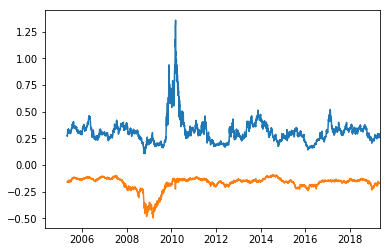

In [382]:
# Average increase and decrease over a give time period
prices = px_close.dropna(subset=['^GSPC'])[tickers]
excl_tickers = list(prices.iloc[-1].isna().loc[prices.iloc[-1].isna().values].index)
prices = prices[excl(prices.columns, excl_tickers)]
look_back = 252
prices.pct_change(look_back).where(prices.pct_change(look_back) > 0).mean(1).plot()
prices.pct_change(look_back).where(prices.pct_change(look_back) < 0).mean(1).plot()

In [388]:
get_return_intervals(prices, 120, tresholds=[0.25, 0.75])

(-inf,
 -0.1765727996826172,
 -0.10733877867460251,
 0.14041641354560852,
 0.2519582509994507,
 inf)

#### Date and minute based time analysis

In [ ]:
freq = '1d'

In [ ]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

In [ ]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

In [ ]:
df.index.date

In [ ]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

In [ ]:
df.tail(5)

In [ ]:
freq = '1d'

In [ ]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

In [ ]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

In [ ]:
f'Ticker: {ticker}'

In [ ]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

#### Old code

In [ ]:
# test distribution of Y variable
tickers = list(mu.sample_sector_tickers(eqty_symbols, profile, sectors, 50).index)
context['grid_search'] = False
context['tickers'] = tickers
context['train_model'] = True

df_large = create_ds(context)

df = df_large.copy()
df.dropna(subset=[y_col], inplace=True)
df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
df.dropna(subset=[y_col], inplace=True) # no nas in y_col
df[y_col] = df[y_col].astype(str) # class as string
sample_wgts(df[y_col])

pred_X, X_traxin, X_test, y_train, y_test = pre_process_ds(df_large, context)
pd.value_counts(discret_rets(df_large.fwdReturn, cut_range, fwd_ret_labels)).sum()
pd.value_counts(pd.concat([y_train, y_test], axis=0)).sum()

In [ ]:
# Test cumulative drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot(
    [l_dd, h_dd], 
    [r_w[l_dd], r_w[h_dd],], 
    'o', color='Red', markersize=10)
plt.plot(
    [l_p, h_p], 
    [r_w[l_p], r_w[h_p]], 
    'o', color='Green', markersize=10)

In [ ]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [ ]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [ ]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [ ]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [ ]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)